## The Billboard Hot 100 Ranking

In this notebook we investigate the original [Billboard Hot 100 Chart](https://www.billboard.com/charts/hot-100/), uncovering the most successful songs and artists over time.

In [1]:
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt

# set mpl parameters for clarity
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.pad'] = 6.0
plt.rcParams['ytick.major.pad'] = 6.0
plt.rcParams['axes.labelpad'] = 6.0
plt.rcParams['legend.edgecolor'] = 'k'

plt.rcParams['pdf.fonttype'] = 42

The data of interest have been scraped previously (see the <a href='0-data_collection.ipynb'>`0-data_collection.ipynb`</a> notebook for details) and stored in the <a href='music_data_scraper\billboard_data.json'>`billboard_data.json`</a> list of dictionaries. The original records are given as follows:

In [2]:
hot_100 = pd.read_json('music_data_scraper/billboard_data.json')\
    .drop_duplicates()

hot_100

,date,pos,artist,song,last_week,peak_pos,wks_on_chart
0,1958-08-04,1,Ricky Nelson,Poor Little Fool,NaN,1,1
1,1958-08-04,2,Perez Prado And His Orchestra,Patricia,NaN,2,1
2,1958-08-04,3,Bobby Darin,Splish Splash,NaN,3,1
3,1958-08-04,4,Elvis Presley With The Jordanaires,Hard Headed Woman,NaN,4,1
4,1958-08-04,5,Kalin Twins,When,NaN,5,1
...,...,...,...,...,...,...,...
338282,2023-05-27,96,Lil Baby Featuring Fridayy,Forever,87.0,8,19
338283,2023-05-27,97,Don Toliver Featuring Justin Bieber & Future,Private Landing,100.0,72,6
338284,2023-05-27,98,YoungBoy Never Broke Again,I Heard,NaN,98,1
338285,2023-05-27,99,Morgan Wallen,Sunrise,89.0,30,11


Using the charts we can investigate the statistics of the most popular songs over decades, but also get the details on the most successful artists in the music industry. Let's start with the former ones, transforming the original data frame to our needs.

In [3]:
# drop unnecessary columns and clarify the dates
hot_100 = hot_100.drop(columns=['last_week', 'peak_pos', 'wks_on_chart'])
hot_100.date = hot_100.date.dt.to_period('W').dt.start_time

# build the tracks data frame
hot_tracks = hot_100.assign(
    track_first_year=lambda x: x.groupby(['artist', 'song']).date\
        .transform(lambda y: y.iloc[0].year), 
    track=lambda x: x.artist + ' - ' + x.song + 
        ' [' + x.track_first_year.astype('str') + ']'
).drop(columns=['artist', 'song', 'track_first_year']).set_index('date')

hot_tracks.sample(5, random_state=0)

,pos,track
date,,
1978-06-26,21,Eric Clapton - Wonderful Tonight [1978]
1959-06-15,26,Tommy Edwards - My Melancholy Baby [1959]
1978-02-06,37,Donna Summer - I Love You [1977]
1965-10-04,42,Andy Williams - Ain't It True [1965]
1976-05-10,44,"The 4 Seasons - December, 1963 (Oh, What a Nig..."


As one can see, we remove three columns (**last_week**, **peak_pos** and **wks_on_chart**) from the Hot 100 data frame, since they can be easily calculated using `pandas` aggregations if needed. Moreover, we transform the Chart dates into the beginning of each week (Mondays) to make them more compatible (the original timestamps are provided with Monday or Saturday schedule; see more details in the previous notebook).

For the resulting `hot_tracks` table, we combine the artist and the song title labels into one, annotating the very first year when the track entered the Billboard List (see the entries with the brackets included in the **track** column). The annotation will allow us to check the song year quickly, when the chart date (stored in the frame index) is not provided.

**Note**: The song release date can differ from the Billboard List entry one (typically no more than a year). Since we will use the date to distinguish between different music decades, a possible small shift is acceptable.

Investigating the `hot_tracks` data frame, we can determine the popularity of songs in relation to various indicators. In the cell given below we present the Top 10 tracks with the highest number of weeks at the no. 1 position (the results account for possible ties, included in the tail).

In [4]:
hot_tracks.query('pos == 1').groupby('track').track\
    .agg('count').nlargest(10, keep='all')

track
Lil Nas X Featuring Billy Ray Cyrus - Old Town Road [2019]                              19
Luis Fonsi & Daddy Yankee Featuring Justin Bieber - Despacito [2017]                    16
Mariah Carey & Boyz II Men - One Sweet Day [1995]                                       16
Harry Styles - As It Was [2022]                                                         15
Boyz II Men - I'll Make Love To You [1994]                                              14
Elton John - Candle In The Wind 1997/Something About The Way You Look Tonight [1997]    14
Los Del Rio - Macarena (Bayside Boys Mix) [1995]                                        14
Mariah Carey - We Belong Together [2005]                                                14
Mark Ronson Featuring Bruno Mars - Uptown Funk! [2014]                                  14
The Black Eyed Peas - I Gotta Feeling [2009]                                            14
Whitney Houston - I Will Always Love You [1992]                                     

The <font color=#ff7f0e>Lil Nas X Featuring Billy Ray Cyrus - Old Town Road</font> song has won the Ranking most often (19 times). On the second (ex aequo) place one can find the <font color=#ff7f0e>Luis Fonsi & Daddy Yankee Featuring Justin Bieber - Despacito</font> and <font color=#ff7f0e>Mariah Carey & Boyz II Men - One Sweet Day</font> tracks (the no. 1 position reached 16 times), while the third place is occupied by Harry Styles and <font color=#ff7f0e>As It Was</font> hit (with 15 wins).

We can change the indicator slightly, determining the <u>uninterrupted</u> number of weeks at the no. 1 position. To get the latter one, we define the `uninter_no_1` tool function and use it on each single track within the aggregated data frame. The results are given as follows:

In [5]:
# the function to determine the uninterrupted number of weeks at no. 1 position
def uninter_no_1(series: pd.Series):
    uninter_no_1_max = 0  # record
    uninter_i = 0  # counter
    
    # examine each record in the series (here, the chart place)
    for rec in series:
        if rec == 1:
            uninter_i += 1
        else:
            if uninter_i > uninter_no_1_max:
                uninter_no_1_max = uninter_i
            if uninter_i > 0:
                uninter_i = 0
    
    if uninter_i > uninter_no_1_max:
        uninter_no_1_max = uninter_i
    
    return uninter_no_1_max

# grab Top 10 songs with the highest uninterrupted records
hot_tracks.groupby('track').pos.agg(uninter_no_1).nlargest(10, keep='all')

track
Lil Nas X Featuring Billy Ray Cyrus - Old Town Road [2019]                              19
Luis Fonsi & Daddy Yankee Featuring Justin Bieber - Despacito [2017]                    16
Mariah Carey & Boyz II Men - One Sweet Day [1995]                                       16
Boyz II Men - I'll Make Love To You [1994]                                              14
Elton John - Candle In The Wind 1997/Something About The Way You Look Tonight [1997]    14
Los Del Rio - Macarena (Bayside Boys Mix) [1995]                                        14
Mark Ronson Featuring Bruno Mars - Uptown Funk! [2014]                                  14
The Black Eyed Peas - I Gotta Feeling [2009]                                            14
Whitney Houston - I Will Always Love You [1992]                                         14
Boyz II Men - End Of The Road (From "Boomerang") [1992]                                 13
Brandy & Monica - The Boy Is Mine [1998]                                            

In this case, the highest three results are the same as previously, but <font color=#ff7f0e>Harry Styles's As It Was</font> fell off the list. Querying for the song data, one can see that in the beginning period of its popularity, it oscillated within first three places, which explains why the uninterrupted record is not very high (5 weeks).

In [6]:
hot_tracks.query('track == "Harry Styles - As It Was [2022]"')

,pos,track
date,,
2022-04-11,1,Harry Styles - As It Was [2022]
2022-04-18,2,Harry Styles - As It Was [2022]
2022-04-25,1,Harry Styles - As It Was [2022]
2022-05-02,1,Harry Styles - As It Was [2022]
2022-05-09,2,Harry Styles - As It Was [2022]
2022-05-16,2,Harry Styles - As It Was [2022]
2022-05-23,2,Harry Styles - As It Was [2022]
2022-05-30,1,Harry Styles - As It Was [2022]
2022-06-06,1,Harry Styles - As It Was [2022]


Another popular metric is the total number of weeks on the Billboard List. We can combine it with the number of weeks at the no. 1 position to see, if the most often occurring tracks (the **no_of_weeks** column) were also the winning ones (the **no_of_1st_place** column).

In [7]:
# tracks with the highest number of weeks on the List
hot_top10_weeks = hot_tracks.groupby('track').track.count()\
    .nlargest(10, keep='all').to_frame('no_of_weeks')

# examine the number of wins for the above
hot_top10_weeks_no1 = hot_tracks[hot_tracks.track.isin(hot_top10_weeks.index)]\
    .query('pos == 1').groupby('track').track.agg('count')\
    .to_frame('no_of_1st_place')

# show the results
pd.concat([hot_top10_weeks, hot_top10_weeks_no1], axis=1)

,no_of_weeks,no_of_1st_place
track,,
Glass Animals - Heat Waves [2021],91,5.0
The Weeknd - Blinding Lights [2019],90,4.0
Imagine Dragons - Radioactive [2012],87,NaN
AWOLNATION - Sail [2011],79,NaN
Dua Lipa - Levitating [2020],77,NaN
Jason Mraz - I'm Yours [2008],76,NaN
LeAnn Rimes - How Do I Live [1997],69,NaN
The Weeknd & Ariana Grande - Save Your Tears [2020],69,2.0
LMFAO Featuring Lauren Bennett & GoonRock - Party Rock Anthem [2011],68,6.0


The <font color=#ff7f0e>Glass Animals - Heat Waves</font> song appeared on 91 charts in total (the highest result), but reached the 1st place only five times. A similar result can be observed for <font color=#ff7f0e>The Weeknd's Blinding Lights</font> hit (90 charts, four wins) and the <font color=#ff7f0e>Imagine Dragons - Radioactive</font> track - 87 weeks on the List but no wins at all (the 'NaN' marker). The data show that being present on the Ranking for many weeks does not guarantee winning it.

We can also see the longest continuous stays on the List, i.e., stays without re-entering. As in the previous scenario (with the number of weeks at the first place), the results obtained for total and uninterrupted cases differ.

In [8]:
# the function to determine the uninterrupted number of weeks on the List
def uninter_weeks(index: pd.Index):
    uninter_weeks_max = 1  # record
    uninter_i = 1  # counter
    
    # examine each record in the index (here, the chart date)
    for i in range(1, index.size):
        weeks_diff = index[i] - index[i - 1] == pd.Timedelta(days=7)

        if weeks_diff:
            uninter_i += 1
        else:
            if uninter_i > uninter_weeks_max:
                uninter_weeks_max = uninter_i
            if uninter_i > 0:
                uninter_i = 1
    
    if uninter_i > uninter_weeks_max:
        uninter_weeks_max = uninter_i
    
    return uninter_weeks_max

# grab Top 10 songs with the highest uninterrupted weeks
hot_tracks.groupby('track').track.agg(lambda x: uninter_weeks(x.index))\
    .nlargest(10, keep='all')

track
Glass Animals - Heat Waves [2021]                                       90
Imagine Dragons - Radioactive [2012]                                    85
Jason Mraz - I'm Yours [2008]                                           76
LeAnn Rimes - How Do I Live [1997]                                      69
OneRepublic - Counting Stars [2013]                                     68
LMFAO Featuring Lauren Bennett & GoonRock - Party Rock Anthem [2011]    67
Jewel - Foolish Games/You Were Meant For Me [1996]                      65
Adele - Rolling In The Deep [2010]                                      64
Carrie Underwood - Before He Cheats [2006]                              64
The Kid LAROI & Justin Bieber - Stay [2021]                             63
Name: track, dtype: int64

Examining the appearances and re-enters of the tracks, we can correlate our data with some of the real-world events which have an impact on what people listen to. In the series presented below, we annotate the songs with the difference (in weeks) between the last date and the first date of their occurrence on the Billboard List.

In [9]:
hot_tracks.reset_index().groupby('track').date\
    .agg(lambda x: x.iloc[-1] - x.iloc[0]).sort_values(ascending=False)\
    .apply(lambda x: f'{x.days/7:.0f} weeks').iloc[:10]

track
Chuck Berry - Run Rudolph Run [1958]                                  3342 weeks
Bobby Helms - Jingle Bell Rock [1958]                                 3341 weeks
Bing Crosby - White Christmas [1958]                                  3341 weeks
Nat King Cole - The Christmas Song (Merry Christmas To You) [1960]    3238 weeks
Brenda Lee - Rockin' Around The Christmas Tree [1960]                 3238 weeks
Bobby "Boris" Pickett And The Crypt-Kickers - Monster Mash [1962]     3140 weeks
Eagles - Please Come Home For Christmas [1978]                        2300 weeks
Fleetwood Mac - Dreams [1977]                                         2273 weeks
David Bowie - Space Oddity [1973]                                     2244 weeks
Queen - Bohemian Rhapsody [1975]                                      2239 weeks
Name: date, dtype: object

The highest records correspond to few Christmas songs which have been released around the 50s/60s and re-entered the Ranking in recent years around the Christmas period (e.g., the <font color=#ff7f0e>Chuck Berry - Run Rudolph Run [1958]</font> song in the 2023-01-02 chart). On the other hand, the <font color=#ff7f0e>David Bowie - Space Oddity [1973]</font> track re-entered the Billboard of 2016-01-25, which correlates with the artist's date of death (January 10th, 2016), while the <font color=#ff7f0e>Queen's Bohemian Rhapsody</font> hit from 1975 reappeared in November 2018, shortly after the movie about the band was released (October 2018). All the corresponding (last appearance) dates for the discussed examples are included in the cell below.

In [10]:
hot_tracks[
    hot_tracks.track.isin([
        'Chuck Berry - Run Rudolph Run [1958]', 
        'David Bowie - Space Oddity [1973]', 
        'Queen - Bohemian Rhapsody [1975]'
    ])
].groupby('track').track.agg(last_appearance=lambda x: x.index[-1])

,last_appearance
track,
Chuck Berry - Run Rudolph Run [1958],2023-01-02
David Bowie - Space Oddity [1973],2016-01-25
Queen - Bohemian Rhapsody [1975],2018-11-26


An interesting case is the <font color=#ff7f0e>Mariah Carey's All I Want For Christmas Is You</font> song, which debuted on 2000-01-03 chart. Then for a very long time the track was absent, but reappeared around December 2012. In the following years, the song regularly re-entered the rankings around the Christmas period, and starting from 2019, it even reached the 1st place. The summary of the track popularity in the last five winters can be found in the next cell.

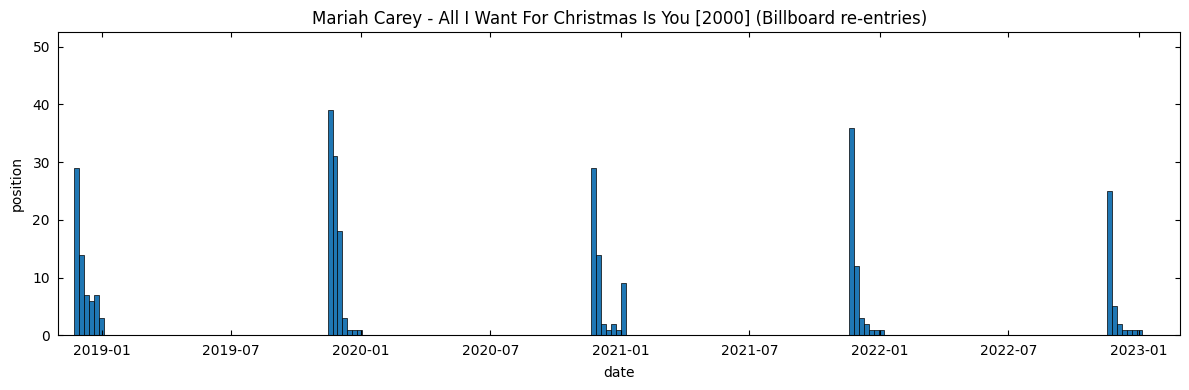

In [11]:
MC_Christmas = 'Mariah Carey - All I Want For Christmas Is You [2000]'

fig, axes = plt.subplots(figsize=(12, 4))

# grab the song re-entries
MC_bb = hot_tracks.query(f'track == "{MC_Christmas}"').reset_index().iloc[1:]

# and plot them using bar chart
axes.bar(
    MC_bb.date, MC_bb.pos, 
    width=dt.timedelta(weeks=1), 
    linewidth=0.5, edgecolor='k'
)

axes.set_xlim(pd.Period('2018-10'), pd.Period('2023-02'))
axes.set(
    xlabel='date', ylabel='position', 
    title=MC_Christmas+' (Billboard re-entries)'
);

plt.tight_layout()

The metrics discussed above do not determine how well the songs did throughout their entire presence on the List. Incorporating the dynamics, we can estimate the general values of the tracks and indicate the most successful ones.

Let's supplement our data with a simple **score** indicator, evaluating each track based on its position in the chart (100 points for being on the 1st place, 99 points for occupying the 2nd place and so on; see also the <a href='0-data_collection.ipynb'>`0-data_collection.ipynb`</a> notebook, where the same notation has been used to collect the <a href='music_data_scraper\billboard_500_yearly.json'>Top 500 yearly data</a>). Investigating the total score value for each song, we can rank their musical potential in the most comprehensive way.

In [12]:
hot_tracks.assign(score=lambda x: 101 - x.pos)\
    .groupby('track').score.sum().nlargest(10, keep='all')

track
The Weeknd - Blinding Lights [2019]                    8089
Glass Animals - Heat Waves [2021]                      7193
Dua Lipa - Levitating [2020]                           6706
Imagine Dragons - Radioactive [2012]                   5932
The Kid LAROI & Justin Bieber - Stay [2021]            5864
The Weeknd & Ariana Grande - Save Your Tears [2020]    5811
Post Malone - Circles [2019]                           5625
LeAnn Rimes - How Do I Live [1997]                     5615
Jewel - Foolish Games/You Were Meant For Me [1996]     5499
Jason Mraz - I'm Yours [2008]                          5433
Name: score, dtype: int64

<font color=#ff7f0e>The Weeknd's Blinding Lights</font> hit is the undisputed leader with 8089 points in total. Almost 900 points lower one can find the <font color=#ff7f0e>Glass Animals Heat Waves</font> song, and on the 3rd position, the <font color=#ff7f0e>Dua Lipa's Levitating</font> track (6706 points). Many of the results included above can be also found in the *'total number of weeks'* ranking presented previously, since the more often the track occupies the List, the more points can it get. It should be noted that most of the songs discussed here are also quite recent ones (above the 2000s/2010s).

Before we investigate the artists data, we can also determine the songs which entered the Billboard List with the 1st place (i.e., the very first week of their appearance was also the winning one). We omit the beginning <font color=#ff7f0e>Ricky Nelson - Poor Little Fool</font> record, which corresponds to the very first Billboard chart dated 1958-08-04.

In [13]:
hot_1st_week_1st_place = hot_tracks.reset_index()\
    .groupby('track').first().query('pos == 1')\
    .sort_values('date')[['date']].iloc[1:]

hot_1st_week_1st_place

,date
track,
Michael Jackson - You Are Not Alone [1995],1995-08-28
Mariah Carey - Fantasy [1995],1995-09-25
"Whitney Houston - Exhale (Shoop Shoop) (From ""Waiting To Exhale"") [1995]",1995-11-20
Mariah Carey & Boyz II Men - One Sweet Day [1995],1995-11-27
Puff Daddy & Faith Evans Featuring 112 - I'll Be Missing You [1997],1997-06-09
...,...
Drake Featuring 21 Savage - Jimmy Cooks [2022],2022-06-27
Nicki Minaj - Super Freaky Girl [2022],2022-08-22
Taylor Swift - Anti-Hero [2022],2022-10-31


As we can see, the scenario occurred for 67 tracks only and includes 1995 onwards. In fact, all the results presented so far relate to the songs from the 90s or after 2000, which shows how the music market diversity changed (before the 90s, it was harder for the song to remain popular for a longer period of time than nowadays).

Aggregating the above data frame by date, we can easily count how many *'first week first place'* songs occurred in each year (see the bar plot included below). A wast majority of the results is below four (tracks per year), excluding 2020-2022 with much higher records. The latter years correspond to the period of the global COVID-19 pandemic, which can somewhat correlate with the observed results.

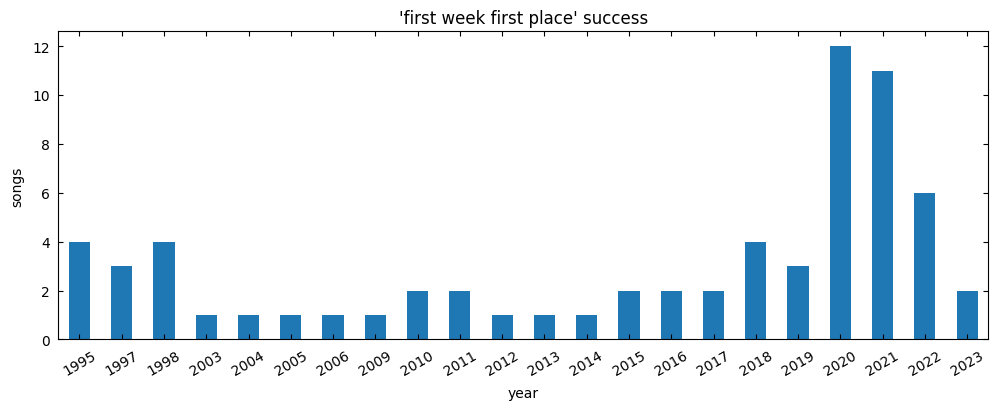

In [14]:
hot_1st_week_1st_place.date.dt.year.value_counts().sort_index().plot.bar(
    xlabel='year', ylabel='songs', title='\'first week first place\' success', 
    rot=30, figsize=(12, 4)
);

Now let's focus on the artists' statistics, investigating the most successful creators who found their way to the Billboard Hot 100 Ranking.

We begin with creating the `hot_artists` data frame which annotates each artist with the year of its very first occurrence on the Chart (see also the `hot_tracks` table defined above for comparison). Unfortunately, the original data are not consistent with labeling the artists' collaborations, e.g., they are annotated using 'feat.', 'and', 'with' or 'x' markers, just to mention a few. Since transforming the labels may disrupt some of their original names/aliases (like <font color=#ff7f0e>Lil Nas X</font>, which has been observed above), we will leave them unchanged for the analysis.

**Note**: Leaving the original artists' labels will partly underestimate some of the creators, since the collaborations will be treated as unique, new artists (instead of being counted as a success of every collaborative creator). Hence, the results presented below refer mainly to solo artists/bands, diminishing the value of possible cooperations.

In [15]:
# build the artists frame
hot_artists = hot_100.assign(
    artist_year=lambda x: x.groupby('artist').date\
        .transform(lambda y: y.iloc[0].year), 
    artist=lambda x: x.artist + ' [' + x.artist_year.astype('str') + ']'
).drop(columns=['artist_year']).set_index('date')

hot_artists.sample(5, random_state=0)

,pos,artist,song
date,,,
1978-06-26,21,Eric Clapton [1970],Wonderful Tonight
1959-06-15,26,Tommy Edwards [1958],My Melancholy Baby
1978-02-06,37,Donna Summer [1975],I Love You
1965-10-04,42,Andy Williams [1958],Ain't It True
1976-05-10,44,The 4 Seasons [1962],"December, 1963 (Oh, What a Night)"


At first, we can determine the artists with the highest number of songs found in the Ranking.

In [16]:
hot_artists.groupby('artist').song.nunique().nlargest(10, keep='all')

artist
Glee Cast [2009]                     183
Taylor Swift [2006]                  164
Drake [2009]                         125
YoungBoy Never Broke Again [2017]     80
The Beatles [1964]                    65
Aretha Franklin [1961]                64
Elton John [1970]                     58
The Rolling Stones [1964]             57
Kanye West [2003]                     56
Stevie Wonder [1964]                  54
The Beach Boys [1962]                 54
Name: song, dtype: int64

The first place corresponds to the <font color=#ff7f0e>Glee Cast</font>, which should be rather treated as a conglomerate of artists (see the details on the Glee original TV series [here](https://en.wikipedia.org/wiki/Glee_(TV_series))). Excluding Glee, we can see that the best result belongs to <font color=#ff7f0e>Taylor Swift</font>, which 164 songs were included in the List (each song for at least one week). <font color=#ff7f0e>Drake</font> occupies the second place (with almost 40 songs less), and after another gap of 45 tracks, one can find <font color=#ff7f0e>YoungBoy Never Broke Again</font> (who debuted only in 2017). The differences between further positions become much smaller.

As we have mentioned above, the results include only solo songs without collaborations. We can incorporate the latter ones for selected artists, limiting the cooperations to the scenarios in which the artist was listed as the first creator. Aggregating the data this way, we exclude somewhat the guest appearance cases, focusing only on the leading tracks.

In [17]:
# the artists (tuple and data frame)
artists_n_songs_tup = ('Taylor Swift', 'Drake', 'YoungBoy Never Broke Again')
hot_artists_n_songs = hot_artists[
    hot_artists.artist.str.startswith(artists_n_songs_tup)
]

# count the Billboard songs
for artist in artists_n_songs_tup:
    n = hot_artists_n_songs.query(
        f'artist.str.startswith("{artist}")'
    ).song.nunique()
    print(artist.ljust(len(artists_n_songs_tup[-1])), 
        ':', str(n).rjust(3), 'songs')

Taylor Swift               : 182 songs
Drake                      : 205 songs
YoungBoy Never Broke Again :  88 songs


The inclusion of the original songs <u>with collaborations</u> changes the ranking, placing <font color=#ff7f0e>Drake</font> on the first place with 205 songs. This result is higher than the previous one by 80 tracks (205 vs. 125), showing that almost 40% of Drake's tracks have been published with cooperation. In this scenario, <font color=#ff7f0e>Taylor Swift</font> dropped to the second place with 182 tracks, which implies 18 collaborations (less than 10% of the total).

**Note**: In recent years Taylor Swift has published numerous re-recordings of her songs from the previous albums (the so-called *'Taylor's Versions'*), many of which found their way to the Billboard List. Examining our data, one can see that 36 of these re-recordings are included among the 182 tracks in total.

Similarly to the songs, we can sort the artists by the number of weeks spent on the charts (the week is included if at least one artist's track has been ranked within it).

In [18]:
hot_artists.reset_index().groupby('artist').date.nunique()\
    .nlargest(10, keep='all')

artist
Elton John [1970]       812
Kenny Chesney [1998]    740
Tim McGraw [1994]       711
Madonna [1983]          682
Keith Urban [2000]      663
Stevie Wonder [1964]    614
Taylor Swift [2006]     604
Rod Stewart [1971]      597
Jason Aldean [2005]     588
Chicago [1969]          546
George Strait [1993]    546
Name: date, dtype: int64

In the weekly classification, the first place is occupied by <font color=#ff7f0e>Elton John</font> with 812 weeks in total (more than 15 years). The next two positions belong to country singers: <font color=#ff7f0e>Kenny Chesney</font> (with 740 weeks) and <font color=#ff7f0e>Tim McGraw</font> (711 charts).

The weekly comparison does not include the number of songs within each week, which can clearly improve artist's position. To combine both songs and weeks, we can supplement our data with the **score** indicator, in the same way as we did previously for the tracks.

Using the total score value for each creator, we will rank their musical achievements in the most comprehensive way. The final results presented below are based initially on the list of Top 10 artists with the highest solo scores, which is then improved by adding the available collaborations (but only the ones where the artist has been listed first).

In [19]:
# artists with the highest scores (without collaborations)
artists_top_score = hot_artists.assign(score=lambda x: 101 - x.pos)\
    .groupby('artist').score.sum().nlargest(10, keep='all')\
    .index.str.replace(r' \[(.+)\]', '', regex=True).values

# include collaborations
hot_artists_score_df = hot_artists[
    hot_artists.artist.str.startswith(tuple(artists_top_score))
].assign(score=lambda x: 101 - x.pos)

hot_artists_score_dict = {}

# prepare the score ranking
for artist in artists_top_score:
    n = hot_artists_score_df.query(
        f'artist.str.startswith("{artist}")'
    ).score.sum()
    hot_artists_score_dict[artist] = n

pd.Series(hot_artists_score_dict).sort_values(ascending=False)

Drake              99781
Taylor Swift       80817
Rihanna            64077
Elton John         62687
Madonna            59263
Mariah Carey       56404
Michael Jackson    44856
The Beatles        44208
Stevie Wonder      42617
Rod Stewart        39461
dtype: int64

In the final classification, <font color=#ff7f0e>Drake</font> wins the ranking again (reaching the score of almost 100 000), surpassing <font color=#ff7f0e>Taylor Swift</font> by approximately 20 000 points (mainly because of his collaborative songs). The next position (<font color=#ff7f0e>Rihanna</font>) is lower by around 16 000 points (the score of 64 077), and the differences between further places become much smaller: (the 4th place) <font color=#ff7f0e>Elton John</font> - 62 687, (the 5th place) <font color=#ff7f0e>Madonna</font> - 59 263.

Using our data we can easily determine how many different creators contributed to the Billboard List in each year (marked by blue bars in the cell below). Additionally, we will supplement these results with the number of yearly debuting artists, i.e., the ones which appeared on the Ranking for the very first time (shown in orange; the bars overlap). The years with incomplete charts (1958 and 2023) are excluded from the final plot for clarity.

**Note**: It should be underlined that due to the structure of the artists' labels, each new collaboration in our data is treated as a new (unique) creator.

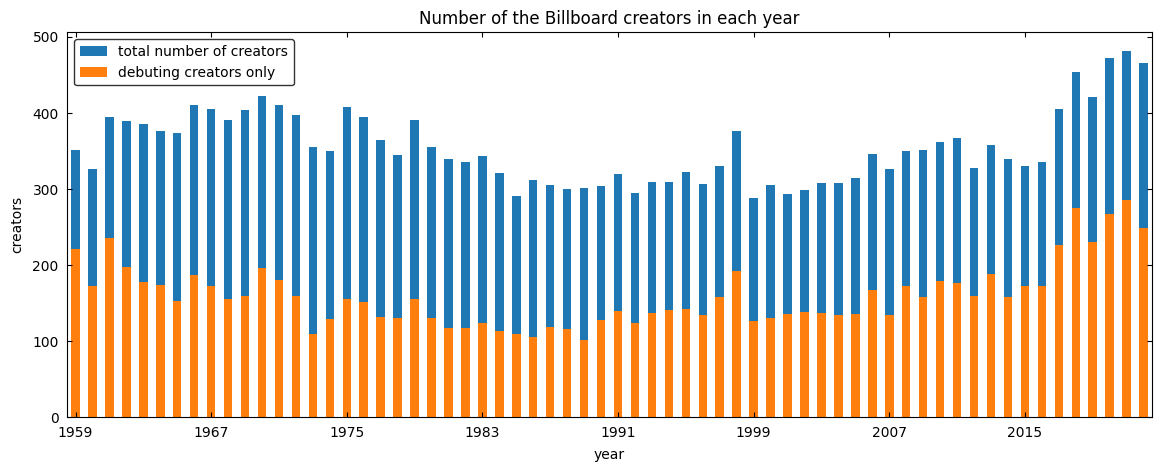

In [20]:
# total number of creators in each year
ax = hot_artists.groupby(pd.Grouper(freq='Y')).artist.nunique()\
    .to_period('Y').iloc[1:-1].plot.bar(figsize=(14, 5), legend=True)

# debuting creators only
hot_artists.assign(
    debut=lambda x: x.index.year == x.artist.str[-5:-1].astype(int)
).loc[lambda x: x.debut, ['artist']]\
.groupby(pd.Grouper(freq='Y')).artist.nunique().to_period('Y').iloc[1:-1]\
.plot.bar(
    ax=ax, color='tab:orange', legend=True, rot=0, 
    xlabel='year', ylabel='creators', 
    title='Number of the Billboard creators in each year'
)

ax.legend(['total number of creators', 'debuting creators only'])
ax.xaxis.set_major_locator(plt.MaxNLocator('auto'))

The results show that the number of the most successful creators remained quite stable and not highly dependent on the considered music decade (for both the total number of artists, as well as the debuting ones). However, in recent years (2015 onwards) we can observe a slow general increases in these numbers (which can be caused by the increasing number of artists and/or new collaborations between them).

We finish our investigations on the Billboard List by defining the `artist_stats` function (see the <a href='utils.py'>`utils.py`</a> file for details), which allows to collect all the basic information and statistics for any chosen artist (the function first `artist` argument; we can provide the Billboard data frame object as the second parameter or let the function load it for us). The tool produces the following files:
* the `solo_songs.json` dictionary, including the artist's solo tracks with their Billboard details,
* the `collab_songs.json` dictionary, with the artist's songs recorded in collaboration (we consider only the tracks in which the artist was listed as the first one),
* the `artist_name_stats.txt` text file, where one can find all the basic artist's statistics, and
* the `artist_name_score.pdf` document, including the plot of the artist's score dynamics (for both solo songs and the ones created in collaborations).

All the files are saved in the designated artist's catalogue, while the function displays the plot stored in the `artist_name_score.pdf` file.

In the next cell we use the tool to grab all the data for Drake (see also the <a href='Drake_stats'>Drake_stats</a> catalogue for the files).

True

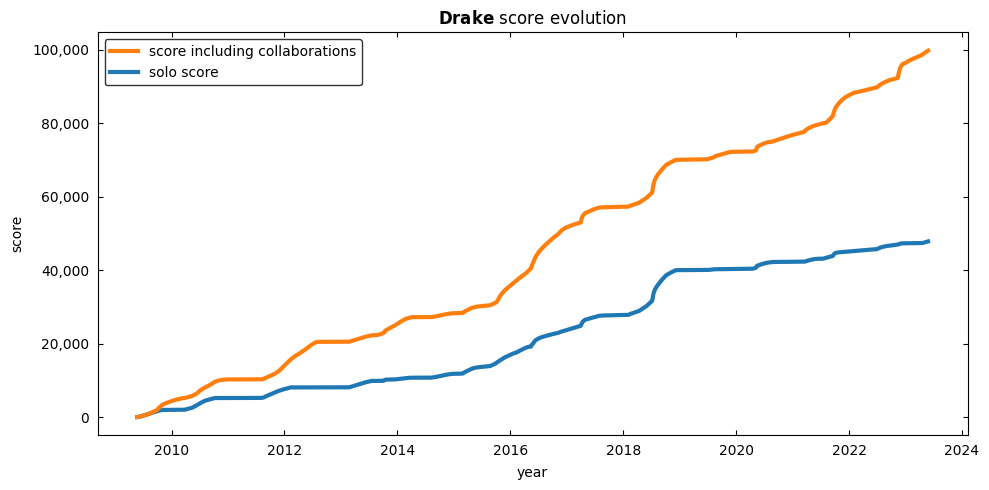

In [21]:
from utils import artist_stats

artist_stats('Drake')

The curves presented above indicate, that Drake's collaborations started in the very beginning of his career and evolved in time much faster than his solo works. Using the graphs we can also indicate the periods of artist's slower development or complete breaks (see the horizontal sections of the curves).

Accessing the basic artist's statistics (the `artist_name_stats.txt` file), we can find most of the information discussed throughout this notebook.

**Note**: The very first and the very last songs (see the results presented below) correspond to the tracks with the highest position within chosen week (the case when the weekly chart contains more than one song of chosen artist). For these categories, the works done in collaboration are excluded.

In [22]:
with open('Drake_stats\Drake_stats.txt') as file:
    print(file.read())

Drake basic statistics


Number of solo songs: 125.
Number of songs in collaboration (as leading artist): 80.

Number of weeks on the Billboard Chart: 553.

The total score based on solo songs only: 47837.
The total score including collaborations (as leading artist): 99781.

The very first song on the Billboard List: 'Best I Ever Had' (on 2009-05-23 ranking, pos: 92).
The very last song on the Billboard List: 'Search & Rescue' (on 2023-05-27 ranking, pos: 17).

The most successful solo song: 'God's Plan' (score: 3267, weeks on Chart: 36, peak position: 1).
The most successful song in collaboration (as leading artist): 'One Dance' by 'Drake Featuring WizKid & Kyla' (score: 3193, weeks on Chart: 36, peak position: 1).


In the next notebook we investigate the musical properties of the most successful songs, uncovering how their features changed over decades; see the <a href='2-audio_features_analysis.ipynb'>`2-audio_features_analysis.ipynb`</a> file for details.